<a href="https://colab.research.google.com/github/jgkorman/Statistical-Analysis-In-Python/blob/main/Assignment_4_PDLA_Korman_JamesG_ICPSR_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ICPSR PDLA Assignment 4**
Author: Korman, James, G



## **Reading in the Data & Descriptive Statistics**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white


In [2]:
dtafile = '/content/drive/MyDrive/Delaware/ICPSR_2022/Panel Data And Longitudinal Analysis/Assignments/Assignment 4_Topics 7 & 8/PSID_long_data_v2.dta'

df = pd.read_stata(dtafile, convert_categoricals=False)
df

,id,wave,paeduc,maeduc,race,totinc,age,educ,SRH,male,marital,evsmoke,time
0,4003.0,7,2.0,2.0,1.0,89560.0,55.0,9.0,NaN,1.0,1.0,0.0,1.0
1,4003.0,9,2.0,2.0,1.0,24960.0,57.0,10.0,NaN,1.0,1.0,0.0,2.0
2,4003.0,11,2.0,2.0,1.0,40416.0,59.0,10.0,NaN,1.0,1.0,0.0,3.0
3,4003.0,13,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,4.0
4,4003.0,15,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84799,6872183.0,9,2.0,4.0,2.0,94210.0,29.0,12.0,NaN,1.0,1.0,1.0,2.0
84800,6872183.0,11,2.0,4.0,2.0,85000.0,31.0,12.0,NaN,1.0,1.0,1.0,3.0
84801,6872183.0,13,2.0,4.0,2.0,91000.0,33.0,14.0,NaN,1.0,1.0,1.0,4.0
84802,6872183.0,15,2.0,4.0,2.0,112000.0,35.0,14.0,NaN,1.0,1.0,1.0,5.0


# **1. Question 1**

*Write out an equation to predict total income (totinc). Be sure to include any dynamics in your equation
that you think might matter (note: testing for dynamics—e.g., unit root tests—given this short a series and
with missing data is very difficult. You probably won’t be able to do this).*

**Answer:** totinc*it* = b0 + b1 X totinc*i*(t-1) + b2 X Maritali(DV) + b3 X age*i*(t-1) + b4 X educ*i*(t-1) + e*it*

**note the lagged DV is for pure illustration purposes (in practice, we would never estiamte a lagged DV with a random effects model due to its correlation with the unobserved errors)

# **2. Question 2** 

*Pick an estimator to use (e.g., pooled, RE, FE, Mundlak, Hausman-Taylor). Why did you choose this
particular estimator?*

**Answer** The estimator I am going to use is going to be a Random Effects witha mundlak device model in order to relax the assumptino that my random effects variables are uncorrelated with unobserved variables (which we no is not ever the case)! With the Mundlak, we area dding a group mean of variables that vary within group for each group. I could take this one step further and also estimate a "hybrid model" that estimates the within group deviations from the group means as IVs along with the group means as variables -- however, we will not go this route for the sake of simplicity -- but doing so would control for even more unobserved heterogeneity. 

In [3]:
y_var_name = 'pcgnp'
X_var_names = ['lpop', 'left', 'year', 'lag_pcgnp']

# **3. Estimating Random intercepts (random effects model with mundlak device & random effects "hybrid" (adding in both mundlak device and within deviations from group means for all X's)** accounting for panel data structure of the dataset

## **a. Data preparation (adding in group means and de-meaned variables)**

In [4]:
group_means = df.groupby('id').mean()[['age', 'educ', 'wave', 'totinc']]
group_means = group_means.reset_index()
group_means


,id,age,educ,wave,totinc
0,4003.0,57.000000,9.666667,12.0,51645.333333
1,4004.0,56.250000,13.500000,12.0,144411.000000
2,4006.0,54.000000,12.000000,12.0,34517.000000
3,4007.0,52.599998,12.000000,12.0,48573.600000
4,4008.0,45.000000,11.000000,12.0,51141.000000
...,...,...,...,...,...
14129,6872172.0,28.200001,13.800000,12.0,79640.400000
14130,6872174.0,26.166666,12.000000,12.0,68003.333333
14131,6872180.0,21.500000,11.000000,12.0,28100.000000
14132,6872182.0,26.000000,12.666667,12.0,27625.000000


In [5]:
# creating a series of every variable in the data frame 
id = group_means['id'].to_list()
age = group_means['age'].to_list()
educ = group_means['educ'].to_list()
wave = group_means['wave'].to_list()
totinc = group_means['totinc'].to_list()

In [6]:
# creating dictionaies with "Id" and every X to map them into the original dataframe 
age_dict = dict(zip(id, age))
educ_dict = dict(zip(id, educ))
wave_dict = dict(zip(id, wave))
totinc_dict = dict(zip(id, totinc))


In [7]:
# mapping the dictionary held values of our group means into the original dataframe 
df['age_group_mean'] = df['id'].map(age_dict)
df['educ_group_mean'] = df['id'].map(educ_dict)
df['wave_group_mean'] = df['id'].map(wave_dict)
df['totinc_group_mean'] = df['id'].map(totinc_dict)
df



,id,wave,paeduc,maeduc,race,totinc,age,educ,SRH,male,marital,evsmoke,time,age_group_mean,educ_group_mean,wave_group_mean,totinc_group_mean
0,4003.0,7,2.0,2.0,1.0,89560.0,55.0,9.0,NaN,1.0,1.0,0.0,1.0,57.0,9.666667,12.0,51645.333333
1,4003.0,9,2.0,2.0,1.0,24960.0,57.0,10.0,NaN,1.0,1.0,0.0,2.0,57.0,9.666667,12.0,51645.333333
2,4003.0,11,2.0,2.0,1.0,40416.0,59.0,10.0,NaN,1.0,1.0,0.0,3.0,57.0,9.666667,12.0,51645.333333
3,4003.0,13,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,4.0,57.0,9.666667,12.0,51645.333333
4,4003.0,15,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,5.0,57.0,9.666667,12.0,51645.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84799,6872183.0,9,2.0,4.0,2.0,94210.0,29.0,12.0,NaN,1.0,1.0,1.0,2.0,32.0,13.000000,12.0,94619.666667
84800,6872183.0,11,2.0,4.0,2.0,85000.0,31.0,12.0,NaN,1.0,1.0,1.0,3.0,32.0,13.000000,12.0,94619.666667
84801,6872183.0,13,2.0,4.0,2.0,91000.0,33.0,14.0,NaN,1.0,1.0,1.0,4.0,32.0,13.000000,12.0,94619.666667
84802,6872183.0,15,2.0,4.0,2.0,112000.0,35.0,14.0,NaN,1.0,1.0,1.0,5.0,32.0,13.000000,12.0,94619.666667


In [8]:
# adding in the within group deviations for estimating the "hybrid" model
df['age_group_mean_deviation'] = df['age'] - df['age_group_mean']
df['educ_group_mean_deviation'] = df['educ'] - df['educ_group_mean']
df['wave_group_mean_deviation'] = df['wave'] - df['wave_group_mean']
df['totinc_group_mean_deviation'] = df['totinc'] - df['totinc_group_mean']
df


,id,wave,paeduc,maeduc,race,totinc,age,educ,SRH,male,...,evsmoke,time,age_group_mean,educ_group_mean,wave_group_mean,totinc_group_mean,age_group_mean_deviation,educ_group_mean_deviation,wave_group_mean_deviation,totinc_group_mean_deviation
0,4003.0,7,2.0,2.0,1.0,89560.0,55.0,9.0,NaN,1.0,...,0.0,1.0,57.0,9.666667,12.0,51645.333333,-2.0,-0.666667,-5.0,37914.666667
1,4003.0,9,2.0,2.0,1.0,24960.0,57.0,10.0,NaN,1.0,...,0.0,2.0,57.0,9.666667,12.0,51645.333333,0.0,0.333333,-3.0,-26685.333333
2,4003.0,11,2.0,2.0,1.0,40416.0,59.0,10.0,NaN,1.0,...,0.0,3.0,57.0,9.666667,12.0,51645.333333,2.0,0.333333,-1.0,-11229.333333
3,4003.0,13,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,...,0.0,4.0,57.0,9.666667,12.0,51645.333333,NaN,NaN,1.0,NaN
4,4003.0,15,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,...,0.0,5.0,57.0,9.666667,12.0,51645.333333,NaN,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84799,6872183.0,9,2.0,4.0,2.0,94210.0,29.0,12.0,NaN,1.0,...,1.0,2.0,32.0,13.000000,12.0,94619.666667,-3.0,-1.000000,-3.0,-409.666667
84800,6872183.0,11,2.0,4.0,2.0,85000.0,31.0,12.0,NaN,1.0,...,1.0,3.0,32.0,13.000000,12.0,94619.666667,-1.0,-1.000000,-1.0,-9619.666667
84801,6872183.0,13,2.0,4.0,2.0,91000.0,33.0,14.0,NaN,1.0,...,1.0,4.0,32.0,13.000000,12.0,94619.666667,1.0,1.000000,1.0,-3619.666667
84802,6872183.0,15,2.0,4.0,2.0,112000.0,35.0,14.0,NaN,1.0,...,1.0,5.0,32.0,13.000000,12.0,94619.666667,3.0,1.000000,3.0,17380.333333


In [9]:
# Now finally, adding in the lags of our IVs and lagged DV
df['lag1_totinc'] = df['totinc'].shift(1)
df['lag1_educ'] = df['educ'].shift(1)
df['lag1_age'] = df['age'].shift(1)
df['lag1_wave'] = df['wave'].shift(1)
df

,id,wave,paeduc,maeduc,race,totinc,age,educ,SRH,male,...,wave_group_mean,totinc_group_mean,age_group_mean_deviation,educ_group_mean_deviation,wave_group_mean_deviation,totinc_group_mean_deviation,lag1_totinc,lag1_educ,lag1_age,lag1_wave
0,4003.0,7,2.0,2.0,1.0,89560.0,55.0,9.0,NaN,1.0,...,12.0,51645.333333,-2.0,-0.666667,-5.0,37914.666667,NaN,NaN,NaN,NaN
1,4003.0,9,2.0,2.0,1.0,24960.0,57.0,10.0,NaN,1.0,...,12.0,51645.333333,0.0,0.333333,-3.0,-26685.333333,89560.0,9.0,55.0,7.0
2,4003.0,11,2.0,2.0,1.0,40416.0,59.0,10.0,NaN,1.0,...,12.0,51645.333333,2.0,0.333333,-1.0,-11229.333333,24960.0,10.0,57.0,9.0
3,4003.0,13,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,...,12.0,51645.333333,NaN,NaN,1.0,NaN,40416.0,10.0,59.0,11.0
4,4003.0,15,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,...,12.0,51645.333333,NaN,NaN,3.0,NaN,NaN,NaN,NaN,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84799,6872183.0,9,2.0,4.0,2.0,94210.0,29.0,12.0,NaN,1.0,...,12.0,94619.666667,-3.0,-1.000000,-3.0,-409.666667,63500.0,12.0,27.0,7.0
84800,6872183.0,11,2.0,4.0,2.0,85000.0,31.0,12.0,NaN,1.0,...,12.0,94619.666667,-1.0,-1.000000,-1.0,-9619.666667,94210.0,12.0,29.0,9.0
84801,6872183.0,13,2.0,4.0,2.0,91000.0,33.0,14.0,NaN,1.0,...,12.0,94619.666667,1.0,1.000000,1.0,-3619.666667,85000.0,12.0,31.0,11.0
84802,6872183.0,15,2.0,4.0,2.0,112000.0,35.0,14.0,NaN,1.0,...,12.0,94619.666667,3.0,1.000000,3.0,17380.333333,91000.0,14.0,33.0,13.0


### **b. Building the model (Pure Random Effects w/ Mundlak device model First w/ lags incorporated into the model)**

In [10]:
# Import and preprocess data
import pandas as pd
!pip install linearmodels



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
df.columns

Index(['id', 'wave', 'paeduc', 'maeduc', 'race', 'totinc', 'age', 'educ',
       'SRH', 'male', 'marital', 'evsmoke', 'time', 'age_group_mean',
       'educ_group_mean', 'wave_group_mean', 'totinc_group_mean',
       'age_group_mean_deviation', 'educ_group_mean_deviation',
       'wave_group_mean_deviation', 'totinc_group_mean_deviation',
       'lag1_totinc', 'lag1_educ', 'lag1_age', 'lag1_wave'],
      dtype='object')

In [12]:
# 1st setting the multidinex (id-year) (corresponding to id-wave in this case for our dataset)
df = df.set_index(['id', 'wave'])

# Perform PooledOLS
from linearmodels import RandomEffects
import statsmodels.api as sm

exog = df[['lag1_totinc', 'lag1_educ', 'lag1_age', 'lag1_wave', 'age_group_mean', 'educ_group_mean', 'wave_group_mean', 'totinc_group_mean']]
exog = sm.tools.tools.add_constant(exog)
endog = df['totinc']
mod = RandomEffects(endog, exog)
RandomEffects_res = mod.fit(cov_type='clustered')

#Store values for checking homoskedasticity graphically
fittedvals_RandomEffects = RandomEffects_res.predict().fitted_values
residuals_RandomEffects = RandomEffects_res.resids

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [13]:

print(RandomEffects_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 totinc   R-squared:                        0.6859
Estimator:              RandomEffects   R-squared (Between):              0.8867
No. Observations:               58631   R-squared (Within):               0.0224
Date:                Fri, Jul 29 2022   R-squared (Overall):              0.6859
Time:                        22:32:59   Log-likelihood                 -7.26e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.829e+04
Entities:                       13252   P-value                           0.0000
Avg Obs:                       4.4243   Distribution:                 F(7,58623)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             2266.6
                            

This model that includes lags is purely non-sensical -- but was done to incorporate dynamic effects into the model. Now I will estimate a series of a pure random effects, a mundlak device model w/ random effects, and a random effects "hybrid model" to compare the differences 

### **c. The pure random effects model**

In [14]:
# note the index is already multi-indexed as set above

exog = df[['educ', 'age', 'marital']]
exog = sm.tools.tools.add_constant(exog)
endog = df['totinc']
mod = RandomEffects(endog, exog)
RandomEffects_res = mod.fit(cov_type='clustered')

#Store values for checking homoskedasticity graphically
fittedvals_RandomEffects = RandomEffects_res.predict().fitted_values
residuals_RandomEffects = RandomEffects_res.resids

print(RandomEffects_res)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                        RandomEffects Estimation Summary                        
Dep. Variable:                 totinc   R-squared:                        0.0232
Estimator:              RandomEffects   R-squared (Between):              0.1084
No. Observations:               62845   R-squared (Within):              -0.0095
Date:                Fri, Jul 29 2022   R-squared (Overall):              0.0769
Time:                        22:33:00   Log-likelihood                -7.881e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      498.05
Entities:                       13945   P-value                           0.0000
Avg Obs:                       4.5066   Distribution:                 F(3,62841)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             341.40
                            

### **d. Estimating the random effects model with mundlak device**

In [15]:
df.columns

Index(['paeduc', 'maeduc', 'race', 'totinc', 'age', 'educ', 'SRH', 'male',
       'marital', 'evsmoke', 'time', 'age_group_mean', 'educ_group_mean',
       'wave_group_mean', 'totinc_group_mean', 'age_group_mean_deviation',
       'educ_group_mean_deviation', 'wave_group_mean_deviation',
       'totinc_group_mean_deviation', 'lag1_totinc', 'lag1_educ', 'lag1_age',
       'lag1_wave'],
      dtype='object')

In [16]:
# note the index is already multi-indexed as set above

exog = df[['educ', 'age', 'marital', 'age_group_mean', 'educ_group_mean']]
exog = sm.tools.tools.add_constant(exog)
endog = df['totinc']
mod = RandomEffects(endog, exog)
RandomEffects_res = mod.fit(cov_type='clustered')

#Store values for checking homoskedasticity graphically
fittedvals_RandomEffects = RandomEffects_res.predict().fitted_values
residuals_RandomEffects = RandomEffects_res.resids

print(RandomEffects_res)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                        RandomEffects Estimation Summary                        
Dep. Variable:                 totinc   R-squared:                        0.0400
Estimator:              RandomEffects   R-squared (Between):              0.1295
No. Observations:               62845   R-squared (Within):               0.0054
Date:                Fri, Jul 29 2022   R-squared (Overall):              0.0987
Time:                        22:33:01   Log-likelihood                -7.875e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      523.59
Entities:                       13945   P-value                           0.0000
Avg Obs:                       4.5066   Distribution:                 F(5,62839)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             273.28
                            

### **e. Estimating "hybrid" model with mundlak device and group mean deviations for our within-varying parameters** 

In [17]:
# note the index is already multi-indexed as set above

exog = df[['age_group_mean_deviation', 'educ_group_mean_deviation', 'marital', 'age_group_mean', 'educ_group_mean']]
exog = sm.tools.tools.add_constant(exog)
endog = df['totinc']
mod = RandomEffects(endog, exog, check_rank=False)
RandomEffects_res = mod.fit(cov_type='clustered')

#Store values for checking homoskedasticity graphically
fittedvals_RandomEffects = RandomEffects_res.predict().fitted_values
residuals_RandomEffects = RandomEffects_res.resids

print(RandomEffects_res)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                        RandomEffects Estimation Summary                        
Dep. Variable:                 totinc   R-squared:                        0.0400
Estimator:              RandomEffects   R-squared (Between):              0.1295
No. Observations:               62845   R-squared (Within):               0.0054
Date:                Fri, Jul 29 2022   R-squared (Overall):              0.0987
Time:                        22:33:02   Log-likelihood                -7.875e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      523.59
Entities:                       13945   P-value                           0.0000
Avg Obs:                       4.5066   Distribution:                 F(5,62839)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             273.28
                            

### **Solution**
Overall, what appears to predict household income is education, and age for both across groups and within groups is a strong positive predictor of household income. Meanwhile, marital status is a negative predictor for household income. Importantly, our random effects model w/ mundlak device performed better overall than our pure random effects model. However, the hybrid model and the pure mundlak device model are showing the same results. This is to be investigated. 

# **Question 4**

Using the wdi_subset.csv, run panel unit root tests on expenditures per capita expenditures_pcgdp, age
dependency ratio agedepratio, and birth rate birthrateper1000. Do you find that any are stationary or
contain a unit root? And do you find evidence of other characteristics such as trends? You don’t need to run
every panel unit root test for each variable, but be sure to run at least two.

In [18]:
import pandas as pd
fname = "/content/drive/MyDrive/Delaware/ICPSR_2022/Panel Data And Longitudinal Analysis/Assignments/Assignment 4_Topics 7 & 8/Copy of wdi_subset.csv"
wdi = pd.read_csv(fname)
wdi


,countryname,countrycode,year,agedepratio,birthrateper1000,expenditures_pcgdp,fdi_pcgdp,gdpgrowth,gdppercapita,gdpgrowth_neg
0,Brazil,BRA,1971,82.931709,34.653999,NaN,NaN,11.295087,5095.5425,0
1,Brazil,BRA,1972,81.901657,34.112000,NaN,NaN,12.052802,5572.0273,0
2,Brazil,BRA,1973,80.826630,33.674999,NaN,NaN,13.978692,6199.8232,0
3,Brazil,BRA,1974,79.637421,33.337002,NaN,NaN,9.042120,6600.5220,0
4,Brazil,BRA,1975,78.337425,33.083000,NaN,1.052467,5.209076,6780.2622,0
...,...,...,...,...,...,...,...,...,...,...
465,United Kingdom,GBR,2013,54.015648,12.100000,39.776093,1.978278,2.046355,40248.7660,0
466,United Kingdom,GBR,2014,54.782848,12.000000,38.965351,1.940550,2.947560,41124.1450,0
467,United Kingdom,GBR,2015,55.535969,11.900000,38.110355,1.565155,2.349121,41756.9220,0
468,United Kingdom,GBR,2016,56.174866,11.800000,37.084900,9.995738,1.789236,42201.6410,0


Text(0.5, 1.0, 'Age Dep Ratio Trend over time')

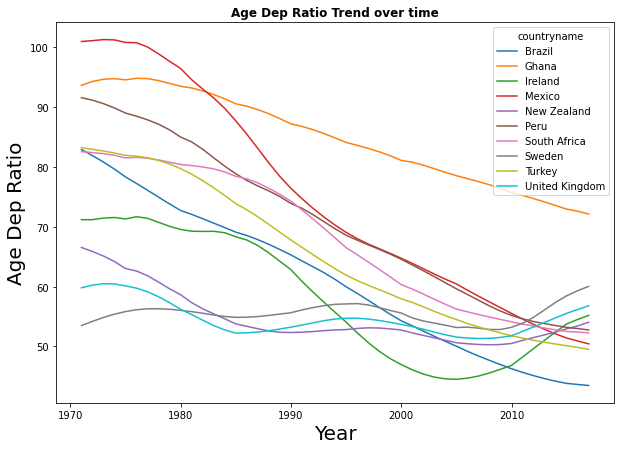

In [19]:
import seaborn as sns



fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(data=wdi, x="year", y="agedepratio", hue="countryname")
plt.ylabel('Age Dep Ratio', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Age Dep Ratio Trend over time', weight='bold')



Text(0.5, 1.0, 'Age Dep Ratio Trend over time')

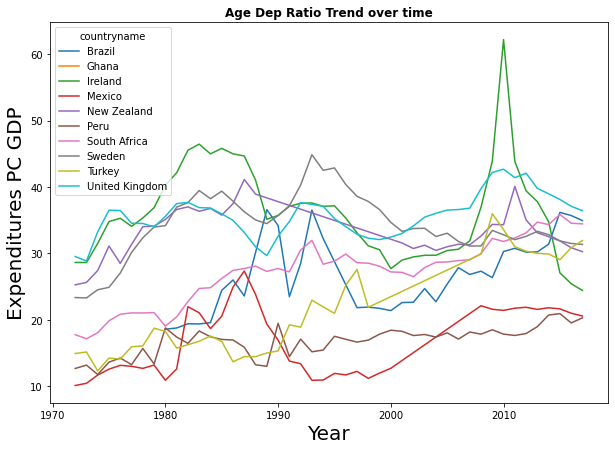

In [20]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(data=wdi, x="year", y="expenditures_pcgdp", hue="countryname")
plt.ylabel('Expenditures PC GDP', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Age Dep Ratio Trend over time', weight='bold')



Text(0.5, 1.0, 'Birth Rate Per 1000 people Trend over time')

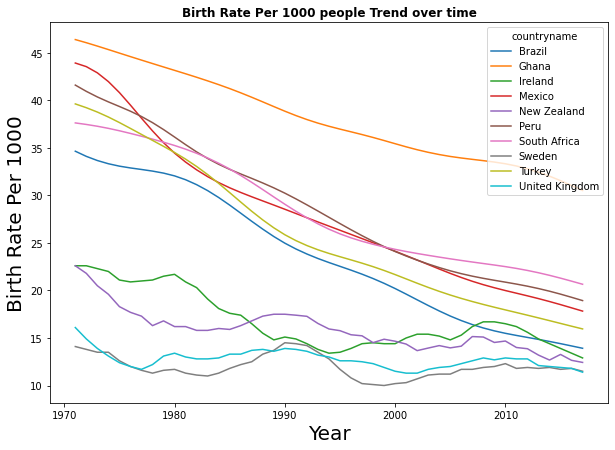

In [25]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(data=wdi, x="year", y="birthrateper1000", hue="countryname")
plt.ylabel('Birth Rate Per 1000', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Birth Rate Per 1000 people Trend over time', weight='bold')

Overall, there is clear trend downwards for all countries for our variables birth rate per 1000 along with agedepratio and a trend upwards for pcgnp. What this entails is most likely non-stationarity for all series involved. Now some panel unit root tests to confrim. 

In [27]:
from statsmodels.tsa.stattools import adfuller

In [31]:
adf_test_result = adfuller(wdi["agedepratio"])
adf_test_result

# age dep ratio is STATIONARY -- WE REJECT THE NULL OF NON-STATIONARITY

(-3.350763721277964,
 0.01275631618568014,
 0,
 469,
 {'1%': -3.444370153876086,
  '10%': -2.5700629410213627,
  '5%': -2.867722323562515},
 2576.957823524438)

In [33]:
adf_test_result = adfuller(wdi["expenditures_pcgdp"].dropna())
adf_test_result
# again the series is stationary! for expenridture pcgdp variable 

(-3.529617526370402,
 0.007258246908525709,
 0,
 375,
 {'1%': -3.447909006729481,
  '10%': -2.5708923751111112,
  '5%': -2.8692783343881483},
 1818.934127352221)

In [34]:
adf_test_result = adfuller(wdi["birthrateper1000"].dropna())
adf_test_result
# again the series is stationary! for expenridture for birthreate per 10000 variable 


(-3.4456461110543635,
 0.009497798962323443,
 0,
 469,
 {'1%': -3.444370153876086,
  '10%': -2.5700629410213627,
  '5%': -2.867722323562515},
 2284.2431634988543)

Please note ** These were estimated as singluar time series due to lack of panel unit root test availability in python ** 